In [1]:
from typing import Literal, NamedTuple, Callable
from pathlib import Path
import re
from math import log10
from itertools import combinations
from warnings import warn
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.classes.digraph import DiGraph
from scipy.spatial import KDTree
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

from lsst.afw.image import ExposureF
from lsst.daf.butler import Butler, DatasetRef
from lsst.sphgeom import LonLat, Box, Angle, Region, Circle
from lsst.rsp import get_tap_service
from lsst.utils.plotting import get_multiband_plot_colors, get_multiband_plot_symbols


filter_names = ['u', 'g', 'r', 'i', 'z', 'y']
filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()

service = get_tap_service("tap")

# Transients graph

With this notebook we take a slight deviation from what we have been worked on so far. 
We try to build a graph for a subset of the sources in the DP1 in the 

## Data loading

### Visits

In [2]:
target_ra, target_dec, radius = 53.160, -28.100, 1.000
t1 = Time("2024-12-01T00:00:00.0", format="isot", scale="tai")
t2 = Time("2024-12-11T00:00:00.0", format="isot", scale="tai")

In [3]:
ccdVisit_astropy = service.search(
    f"SELECT * "
    f"FROM dp1.CcdVisit "
    f"WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {target_ra}, {target_dec}, {radius}))=1"
).to_table()

In [4]:
ccdVisit_df = ccdVisit_astropy.to_pandas()
ccdVisit_df = ccdVisit_df.sort_values("obsStartMJD")
ccdVisit_df = ccdVisit_df[
    (ccdVisit_df["obsStartMJD"] > t1.mjd) & (ccdVisit_df["obsStartMJD"] <= t2.mjd)
]
ccdVisit_df = ccdVisit_df[ccdVisit_df["band"].isin(["i", "r", "g"])]
ccdVisit_df = ccdVisit_df.set_index("ccdVisitId")
ccdVisit_df

,astromOffsetMean,astromOffsetStd,band,darkTime,dec,detector,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,...,urcdec,urcra,xSize,ySize,zenithDistance,zeroPoint,visitId,expMidptMJD,expMidpt,obsStartMJD
ccdVisitId,,,,,,,,,,,,,,,,,,,,,
1145204417024,0.011788,0.006040,r,30.4349,-27.832747,0,11.03380,0.307583,1.244190,0.961064,...,-27.934571,53.401083,4071,3999,11.569500,32.031200,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417029,0.009710,0.004670,r,30.4349,-28.277678,5,11.62860,0.323229,1.247970,0.960937,...,-28.379195,53.082423,4071,3999,11.185300,32.031200,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417030,0.013386,0.006427,r,30.4349,-27.785922,6,11.60530,0.323764,1.242030,0.962005,...,-27.887086,52.871740,4071,3999,11.132600,32.031799,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417028,0.007920,0.004600,r,30.4349,-28.043662,4,12.01310,0.335342,1.240090,0.962919,...,-28.145144,53.109517,4071,3999,11.265800,32.032299,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
1145204417026,0.006943,0.003595,r,30.4349,-28.301220,2,11.82520,0.329259,1.245600,0.961104,...,-28.403017,53.348294,4071,3999,11.407000,32.031300,2024113000162,60645.114372,2024-12-01T02:44:41.724,60645.114198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145279958530,0.023179,0.015518,g,30.4393,-27.809932,2,5.56125,0.293629,0.971333,0.649957,...,-27.804082,53.268005,4071,3999,39.244400,31.968901,2024120900334,60654.249191,2024-12-10T05:58:50.076,60654.249017
1145279958536,0.020684,0.011222,g,30.4393,-28.132990,8,6.02183,0.310483,0.990160,0.652926,...,-28.126629,53.655799,4071,3999,38.832699,31.971399,2024120900334,60654.249191,2024-12-10T05:58:50.076,60654.249017
1145279958529,0.021564,0.012750,g,30.4393,-27.980819,1,5.64783,0.298487,0.968846,0.651000,...,-27.975465,53.084857,4071,3999,39.358101,31.969801,2024120900334,60654.249191,2024-12-10T05:58:50.076,60654.249017


In [ ]:
job = service.submit_job(
    f"SELECT coord_dec ,coord_decErr, coord_ra, coord_raErr  "
    f"FROM dp1.Object "
    f"WHERE CONTAINS(POINT('ICRS',  coord_ra , coord_dec), CIRCLE('ICRS', {target_ra}, {target_dec}, {radius}))=1"
)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

In [ ]:
objects_df = job.fetch_result().to_table().to_pandas()

### Sources

In [5]:
ccdVisit_ids = pd.unique(ccdVisit_df["visitId"])
ccdVisit_ids_str = "(" + ", ".join(map(str, ccdVisit_ids)) + ")"

job = service.submit_job(
    f"SELECT * "
    f"FROM dp1.DiaSource "
    f"WHERE visit IN {ccdVisit_ids_str}"
)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [6]:
diaSource_df = job.fetch_result().to_table().to_pandas()
diaSource_df = diaSource_df.set_index("diaSourceId")
diaSource_df

,apFlux,apFlux_flag,apFlux_flag_apertureTruncated,apFluxErr,band,bboxSize,centroid_flag,coord_dec,coord_ra,dec,...,trailAngle,trailDec,trailFlux,trailLength,trailRa,visit,x,xErr,y,yErr
diaSourceId,,,,,,,,,,,,,,,,,,,,,
600443333482905696,1069.469971,False,False,890.211975,i,14,False,-28.590007,52.718267,-28.590025,...,NaN,NaN,NaN,NaN,NaN,2024120600250,1917.593476,0.419715,169.966904,0.279794
600456536749244446,1193.829956,True,False,400.970001,g,18,True,-28.606552,52.691533,-28.606552,...,NaN,NaN,NaN,NaN,NaN,2024120900318,375.000000,NaN,591.000000,NaN
600430123371462713,-443.009003,False,False,690.856995,i,20,False,-28.613023,52.723238,-28.612954,...,-71.335993,-28.612872,-1968.790039,0.861423,52.723312,2024120300131,1542.340425,NaN,324.882108,NaN
600447737703432197,-538.499023,False,False,532.716003,r,25,False,-28.599969,52.684427,-28.599934,...,-57.211209,-28.600067,-4943.180176,0.976359,52.684388,2024120700296,601.069715,NaN,247.500000,NaN
600447737703432194,354.121002,False,False,490.843994,r,23,False,-28.615174,52.680066,-28.615144,...,-59.875755,-28.615257,-3284.389893,0.925261,52.679989,2024120700296,355.219228,NaN,109.335754,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600443336438841445,-900.723999,False,False,577.968994,r,14,False,-28.104641,53.572437,-28.104614,...,-5.760851,-28.104653,-2109.459961,1.340927,53.572427,2024120600272,3760.570231,0.576006,3883.108519,0.412210
600443336438841443,-565.924988,False,False,407.337006,r,14,False,-28.101358,53.518276,-28.101358,...,NaN,NaN,NaN,NaN,NaN,2024120600272,4005.723489,0.310771,3059.218120,0.438441
600443336438841439,-1339.520020,False,False,404.859009,r,15,False,-28.111308,53.503747,-28.111285,...,69.051669,-28.111287,-1214.640015,1.961127,53.503773,2024120600272,3881.936145,0.768096,2796.043064,1.122960


### Source filtering

In [7]:
def verbose(func):
    def msg_wrapper(df: pd.DataFrame, *args, **kwargs):
        len_before, len_before_cols = len(df), len(df.columns)

        df = func(df, *args, *kwargs)
        if (diff := len_before - len(df)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} rows ({100 * float(abs(diff / len_before)):.2f} %, originally: {len_before})")
        if (diff := len_before_cols - len(df.columns)):
            print(f"{func.__name__} {'cut' if diff > 0 else 'added'} {abs(diff)} columns (originally: {len_before_cols})")
        return df
    return msg_wrapper


flag_columns = [
    "pixelFlags_cr",
    "pixelFlags_crCenter",
    "centroid_flag",
    "apFlux_flag",
    "isDipole",
    # next flags are from Liu 2024
    "pixelFlags_saturated",
    "pixelFlags_saturatedCenter",
    "pixelFlags_suspect",
    "pixelFlags_suspectCenter",
    "pixelFlags_streak",
    "pixelFlags_streakCenter",
    "pixelFlags_offimage",
    "pixelFlags_bad",
    "psfFlux_flag",
    "shape_flag",
]

def filter_flags(df: pd.DataFrame, flag_columns: list[str]) -> pd.DataFrame:
    for flag in flag_columns:
        def filter_func(df: pd.DataFrame, flag_name: str = flag) -> pd.DataFrame:
            return df[~df[flag_name]]
        
        filter_func.__name__ = f"filter_{flag}"
        df = verbose(filter_func)(df)
    return df
    

@verbose
def filter_nans(df: pd.DataFrame) -> pd.DataFrame:
    return df.dropna(subset=["ra", "dec", "raErr", "decErr"])


# diaSource_df = filter_nans(filter_flags(diaSource_df))
diaSource_df = filter_nans(filter_flags(diaSource_df, flag_columns))

filter_pixelFlags_cr cut 898 rows (0.49 %, originally: 183890)
filter_centroid_flag cut 32469 rows (17.74 %, originally: 182992)
filter_apFlux_flag cut 52 rows (0.03 %, originally: 150523)
filter_isDipole cut 68781 rows (45.71 %, originally: 150471)
filter_pixelFlags_saturated cut 2044 rows (2.50 %, originally: 81690)
filter_pixelFlags_suspect cut 166 rows (0.21 %, originally: 79646)
filter_pixelFlags_streak cut 741 rows (0.93 %, originally: 79480)
filter_shape_flag cut 23801 rows (30.23 %, originally: 78739)
filter_nans cut 41 rows (0.07 %, originally: 54938)


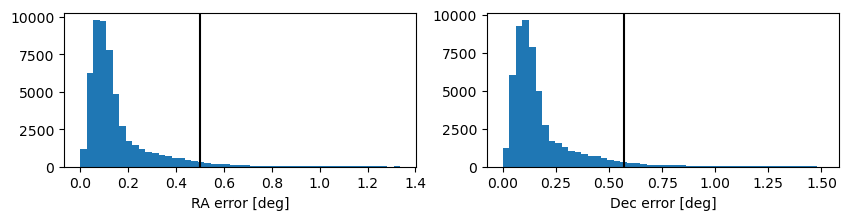

The 95.0-percentile RA error is 0.50 arcsec
The 95.0-percentile dec error is 0.57 arcsec


In [8]:
import matplotlib.pyplot as plt

q = 0.95

fig, axs = plt.subplots(1,2, figsize=(10, 2))
_  = axs[0].hist(_raErrs_arcsec := diaSource_df["raErr"] * 3600, bins=np.linspace(0, np.quantile(_raErrs_arcsec, 0.99), 50))
axs[0].axvline(np.quantile(_raErrs_arcsec, q), color="k")
axs[0].set_xlabel("RA error [deg]")
_  = axs[1].hist(_decErrs_arcsec := diaSource_df["decErr"] * 3600, bins=np.linspace(0, np.quantile(_decErrs_arcsec, 0.99), 50))
axs[1].axvline(np.quantile(_decErrs_arcsec, q), color="k")
axs[1].set_xlabel("Dec error [deg]")
plt.show()

print(f"The {100 * q}-percentile RA error is {np.quantile(_raErrs_arcsec, q):.2f} arcsec")
print(f"The {100 * q}-percentile dec error is {np.quantile(_decErrs_arcsec, q):.2f} arcsec")

In [9]:
@verbose
def filter_coorderr(df: pd.DataFrame, quantile: float)  -> pd.DataFrame:
    return df[
        (df["raErr"] < np.quantile(df["raErr"], quantile)) &
        (df["decErr"] < np.quantile(df["decErr"], quantile))
    ]

diaSource_df = filter_coorderr(diaSource_df, 0.95)

filter_coorderr cut 3656 rows (6.66 %, originally: 54897)


# Source matching: KD-Tree indexing

In [102]:
def sph2xyz(
    lons: np.array, 
    lats: np.array, 
    *,
    units: Literal["radians", "degrees"],
) -> np.array:
    if units == "degrees":
        lons = np.radians(lons)
        lats = np.radians(lats)

    x = (cos_lat_rad := np.cos(lats)) * np.cos(lons)
    y = cos_lat_rad * np.sin(lons)
    z = np.sin(lats)
    return np.column_stack([x, y, z])


def search_radius(
    tree: KDTree,
    center_lon: float, 
    center_lat: float, 
    radius: float,
    *,
    units: Literal["radians", "degrees"]="degrees",
) -> np.array:
    if units == "degrees":
        center_lon = np.radians(center_lon)
        center_lat = np.radians(center_lat)
        radius = np.radians(radius)
        
    # radius = np.sqrt(width ** 2 + height ** 2) / 2  # radians
    if radius > 0.5: 
        warn("Search radius too large for small-angle approximation. Error exceeding 5%.")

    center_xyz = sph2xyz(center_lon, center_lat, units="radians").reshape(-1)
    idxs = tree.query_ball_point(center_xyz, r=radius)
    return idxs


def _map_source2ccdVisit(sources: pd.DataFrame, ccdVisits: pd.DataFrame) -> dict:
   visit_lookup = {
       (row['visitId'], row['detector']): idx 
       for idx, row in ccdVisits.iterrows()
   }
   return {
       idx: visit_lookup.get((row['visit'], row['detector']))
       for idx, row in sources.iterrows()
   }


def _map_v2region(
    ccdVisits: pd.DataFrame,
) -> dict:
    return {
        visit_index: Region.from_ivoa_pos(
            f"POLYGON "
            f"{visit['llcra']} {visit['llcdec']} "
            f"{visit['lrcra']} {visit['lrcdec']} "
            f"{visit['ulcra']} {visit['ulcdec']} "
            f"{visit['urcra']} {visit['urcdec']}"
        )
        for visit_index, visit in ccdVisits.iterrows()
    }


def _map_s2region(
    sources: pd.DataFrame,
    nstd: int=1,
) -> dict:
    return {
        source_index: Box(
            center=LonLat.fromDegrees(source["ra"], source["dec"]),
            # we divide by two because the constructor takes half-width and half-height
            # http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1sphgeom_1_1_box.html
            width=Angle.fromDegrees(nstd * source["raErr"]) / 2,
            height=Angle.fromDegrees(nstd * source["decErr"]) / 2,
        )
        for source_index, source in sources.iterrows()
    }



class SourceTree:
    def __init__(
        self,
        diaSource: pd.DataFrame,
        ccdVisit: pd.DataFrame,
        radius_quantile: float = 0.99,
        nstd: int = 5,
        logger: Callable = lambda _: None,
    ):
        """
        sources and ccdVisits defined according to DP1 schema
        cf. `https://sdm-schemas.lsst.io/dp1.html`
        """
        self.diaSource = diaSource
        self.ccdVisit = ccdVisit
        self.nstd = nstd
        self.radius_quantile = radius_quantile
        self.logger = logger
        
        self.logger("Mapping diaSource to CCD visit..")
        self.map_s2v = _map_source2ccdVisit(diaSource, ccdVisit)
        self.logger("Mapping diaSource to regions..")
        self.map_s2r = _map_s2region(diaSource, nstd)
        self.logger("Building 2D-tree..")
        self.tree = KDTree(sph2xyz(diaSource["ra"], diaSource["dec"], units="degrees"))
        # this quantity will control the number of sources to test for closeness
        # it requires some fine tuning: a value too small will result in missed sources
        # a value too large will slow the algorithm
        self._radius = 2 * nstd * np.sqrt(
            np.quantile(diaSource['raErr'], radius_quantile) ** 2 + 
            np.quantile(diaSource['decErr'], radius_quantile) ** 2
        )

    def _source_time(self, source_index: int) -> float:
        return self.ccdVisit.loc[self.map_s2v[source_index]]["obsStartMJD"]

    def _source_band(self, source_index: int) -> str:
        return self.ccdVisit.loc[self.map_s2v[source_index]]["band"]

    def search_radius(
        self,
        ra: float, 
        dec: float, 
        radius: float,
    ) -> list:
        position_indexes = search_radius(self.tree, ra, dec, radius, units="degrees")
        return sorted(
            self.diaSource.index[position_indexes], 
            key=self._source_time,
        )

    def search_close(
        self,
        source_index: int
    ) -> list:
        ra, dec = self.diaSource.loc[source_index][["ra", "dec"]]
        candidate_ids = self.search_radius(ra, dec, self._radius)
        # always contains the source index itself so we remove it
        candidate_ids.remove(source_index)
        return sorted([*filter(
               lambda idx: self.map_s2r[idx].overlaps(self.map_s2r[source_index]),
                candidate_ids,
            )],
            key=self._source_time,
        )
        
st = SourceTree(diaSource_df, ccdVisit_df, nstd=5, logger = print)

Mapping diaSource to CCD visit..
Mapping diaSource to regions..
Building 2D-tree..


# DiaSources Graph

In [103]:
def tree2graph(tree: SourceTree) -> DiGraph:
    from tqdm.notebook import tqdm
    
    G = nx.DiGraph()
    for diaSource_index, diaSource in tqdm(tree.diaSource.iterrows(), total=len(tree.diaSource), desc="Building graph"):
        source_time = tree._source_time(diaSource_index)
        for match_index in tree.search_close(diaSource_index):
            if source_time < (match_time := tree._source_time(match_index)):
                G.add_edge(diaSource_index, match_index)
                G.nodes[diaSource_index]["obsStartMJD"] = source_time
                G.nodes[match_index]["obsStartMJD"] = match_time
                
    TR = nx.transitive_reduction(G)
    TR.add_nodes_from(G.nodes(data=True))
    TR.add_edges_from((u, v, G.edges[u, v]) for u, v in TR.edges)
    return TR


graph = tree2graph(st)

Building graph:   0%|          | 0/51241 [00:00<?, ?it/s]

In [109]:
def graph2components(graph: DiGraph, minsize: int = 1) -> list[list]:
    return [*filter(
        # remove weak components shorter than minsize
        lambda xs: len(xs) >= minsize, 
        # transforms set to list and sort sources by time
        map(
            lambda xs: sorted([*xs], key=lambda x: graph.nodes[x]["obsStartMJD"]), 
            nx.weakly_connected_components(graph)),
    )]


wcomps = graph2components(graph, minsize=2)

# Catalog crossmatch

In [110]:
def comps2circles(comps, map_s2r: dict) -> list[Circle]:
    return  [
        reduce(
            lambda x, y: x.expandTo(y), 
            map(lambda x: map_s2r[x], cs),
            # this will avoid dieing on lists with one element
            # it works since .expandTo() is idempotent
            map_s2r[cs[0]],
        ).getBoundingCircle()
        for cs in comps
    ]

wcomps_circles = comps2circles(wcomps, st.map_s2r)

wcomps_radii = [*map(lambda x: x.getOpeningAngle().asDegrees(), wcomps_circles)]
wcomps_area = [*map(lambda x: x.getArea(), wcomps_circles)] # steradians
wcomps_centers = [*map(lambda x: LonLat(x.getCenter()), wcomps_circles)]

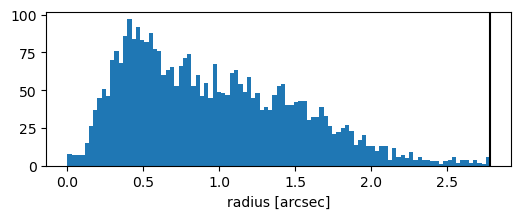

In [131]:
plt.figure(figsize=(6,2))
_ = plt.hist(_rs := [*map(lambda x: x * 3600, wcomps_radii)], bins=np.linspace(0, np.quantile(_rs, _q := 0.99), 100))
plt.axvline(np.quantile(_rs, _q), color = "k")
plt.xlabel("radius [arcsec]")
plt.show()

## Simbad query

In [121]:
from astroquery.simbad import Simbad
from tqdm.notebook import tqdm


def simbad_query(centers: SkyCoord, radii: list, batch_size: int) -> pd.DataFrame:
    from tqdm.notebook import tqdm

    simbad = Simbad()
    # otype field classifies the source (e.g., "G" for galaxies, "QSO" for quasar..)
    simbad.add_votable_fields("otype")
    # in batches, because astroquery appears to silently drop large queries
    results = pd.DataFrame()
    for n in tqdm(
        range(0, len(centers), batch_size), 
    total=len(centers) // batch_size, desc="Querying Simbad"):
        _s = slice(n, n + batch_size)
        results = pd.concat((
            results, 
            simbad.query_region(
                centers[_s], 
                radius=radii[_s],
            ).to_pandas(),
        )).reset_index(drop=True)
    return results

query_centers = SkyCoord(
    ra =[*map(lambda x: x.getLon().asDegrees() * u.deg, wcomps_centers)],
    dec=[*map(lambda x: x.getLat().asDegrees() * u.deg, wcomps_centers)],
)

MIN_RADIUS_DEG, MAX_RADIUS_DEG = 0, np.quantile(wcomps_radii, 0.99)
query_radii = [*map(lambda x: min(max(x, MIN_RADIUS_DEG), MAX_RADIUS_DEG) * u.deg, wcomps_radii)]

simbad_objects_df = simbad_query(query_centers, query_radii, 500)

Querying Simbad:   0%|          | 0/7 [00:00<?, ?it/s]

In [122]:
simbad_objects_df

,main_id,ra,dec,coo_err_maj,coo_err_min,coo_err_angle,coo_wavelength,coo_bibcode,otype
0,SWIRE J033450.21-280420.8,53.709254,-28.072451,3.3747,5.6244,90,O,2020yCat.1350....0G,G
1,DES J033101.16-275125.5,52.754851,-27.857086,0.0759,0.1364,90,O,2020yCat.1350....0G,QSO
2,DES J033017.79-280231.3,52.574162,-28.042030,0.1915,0.3627,90,O,2020yCat.1350....0G,QSO
3,[CBP2015] cdfs2 r 20111028 124A,52.696949,-27.988279,4.2644,10.3240,90,O,2020yCat.1350....0G,SN*
4,WISE J033409.21-275404.1,53.538442,-27.901175,0.7386,1.1408,90,O,2020yCat.1350....0G,G
...,...,...,...,...,...,...,...,...,...
572,DES J033306.78-280914.4,53.278283,-28.154006,NaN,NaN,<NA>,O,2021ApJS..255...20A,AGN
573,DES J033246.76-280846.9,53.194859,-28.146361,0.0801,0.1276,90,O,2020yCat.1350....0G,QSO
574,ATCDFS J033319.03-281432.7,53.329125,-28.242401,4.1436,6.6579,90,O,2020yCat.1350....0G,G
575,SWIRE J033218.03-281247.5,53.075167,-28.213194,NaN,NaN,<NA>,O,2012MNRAS.426.3334M,G


In [123]:
ids, d2d, _ = query_centers.match_to_catalog_sky(SkyCoord(ra=simbad_objects_df["ra"], dec=simbad_objects_df["dec"], unit=u.deg))

In [124]:
associations = [
    (i, wcomps[i], *simbad_objects_df.iloc[ids[i]][["main_id", "otype"]])
    for i in range(len(wcomps))
    if d2d[i] < 2 * u.arcsec  # Filter inline
]

In [125]:
simbad_objects_df.groupby("otype").count()["main_id"].sort_values(ascending=False)

otype
*      288
G      164
QSO     35
rG      23
EmG     15
AGN     12
WD?      8
GiC      6
?        5
SN*      4
Rad      4
X        3
PM*      2
Sy2      2
AG?      1
EmO      1
IG       1
IR       1
Sy1      1
smm      1
Name: main_id, dtype: int64

### Testing against random locations

In [117]:
random_ras = np.random.rand(len(wcomps)) * radius + (target_ra - radius / 2)
random_decs = np.random.rand(len(wcomps)) * radius + (target_dec - radius / 2)
random_centers = SkyCoord(
    ra = random_ras * u.deg,
    dec= random_decs * u.deg,
)
random_simbad_objects_df = simbad_query(random_centers, query_radii, batch_size=500)

Querying Simbad:   0%|          | 0/7 [00:00<?, ?it/s]

In [119]:
len(random_simbad_objects_df)

76

# Exploring the graph

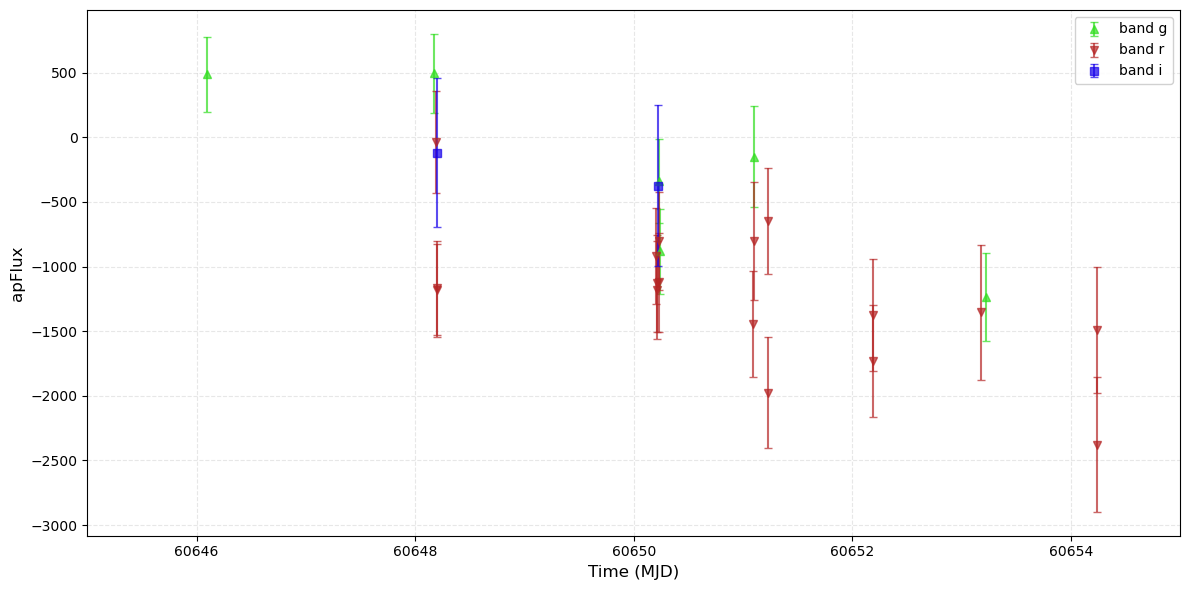

In [128]:
diaSource_ids = [*wcomps[245]]


ys = diaSource_df.loc[diaSource_ids]["apFlux"]
yerrs = diaSource_df.loc[diaSource_ids]["apFluxErr"]
bands = [st._source_band(id_) for id_ in diaSource_ids]
xs = [st._source_time(id_) for id_ in diaSource_ids]

fig, ax = plt.subplots(figsize=(12, 6))

for band in filter_names:
    mask = [b == band for b in bands]
    if not any(mask):
        continue
    
    x_band = [x for x, m in zip(xs, mask) if m]
    y_band = [y for y, m in zip(ys, mask) if m]
    yerr_band = [ye for ye, m in zip(yerrs, mask) if m]
    
    ax.errorbar(
        x_band,
        y_band,
        yerr=yerr_band,
        fmt=filter_symbols[band],
        color=filter_colors[band],
        ecolor=filter_colors[band],
        markersize=6,
        capsize=3,
        capthick=1,
        alpha=0.7,
        label=f'band {band}'
    )

ax.set_xlim(left=t1.mjd, right=t2.mjd)
ax.set_xlabel('Time (MJD)', fontsize=12)
ax.set_ylabel('apFlux', fontsize=12)
ax.legend(loc='best', framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

In [130]:
node_source = 600421335469391977
node_visit = st.map_s2v[node_source]

print(f"visit, detector = {ccdVisit_df.loc[node_visit]["visitId"]}, {ccdVisit_df.loc[node_visit]["detector"]}")
print(f"x, y = {diaSource_df.loc[node_source]["x"]:.2f}, {diaSource_df.loc[node_source]["y"]:.2f}\n\n")
print(f"ra, dec = {diaSource_df.loc[node_source]["ra"]:.6f} {diaSource_df.loc[node_source]["dec"]:.6f}")

print(f"ra, dec = {SkyCoord(ra=diaSource_df.loc[node_source]["ra"] * u.deg,dec=diaSource_df.loc[node_source]["dec"] * u.deg).to_string('hmsdms', precision=2)}")
print(f"Δra, Δdec = {diaSource_df.loc[node_source]["raErr"] * 3600:.5f} {diaSource_df.loc[node_source]["decErr"] * 3600:.5f} (arcsec)")
print(f"snr = {diaSource_df.loc[node_source]["snr"]}")
print(f"apFlux = {diaSource_df.loc[node_source]["apFlux"]}")
print(f"mjd time = {st._source_time(node_source)}")

visit, detector = 2024120100192, 7
x, y = 3957.94, 3247.45


ra, dec = 52.696744 -27.988295
ra, dec = 03h30m47.22s -27d59m17.86s
Δra, Δdec = 0.08559 0.11782 (arcsec)
snr = 6.345334529876709
apFlux = 485.88800048828125
mjd time = 60646.09186553831
